# Imports

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

#Modelling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, classification_report, confusion_matrix, ConfusionMatrixDisplay,mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVR
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

# Oversampling, undersampling, hyperparameter tuning
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

# Scraper for a fighters' specific data

## Screenshot of table one
![Statistics table one](Images/statistics_table_one.png)

## Screenshot of table two
![Statistics table two](Images/statistics_table_two.png)

## Method for scraping fighter specific data

In [1]:
def scrape_fighter_URL(fighter_url):
    try:
        response = requests.get(fighter_url)

        soup = BeautifulSoup(response.content, 'html.parser')

        #Try finding the stats table using the BeautifulSoup, pass the name of the div of the DOM
        stats_table_one = soup.find('div', class_='b-list__info-box-left clearfix')
        
        #Since there are two tables that contain the fighter statistics I need to scrape both the divs
        stats_table_two = soup.find('div', class_='b-list__info-box-right b-list__info-box_style-margin-right')
        
        # A variable to store the data
        statistics = {}
        
        if stats_table_one:
            # Thats the div that contains the stats
            stats_list_one = stats_table_one.find('ul', class_='b-list__box-list b-list__box-list_margin-top')
            # If a the div with the stats is found we iterate through each entry and store it in the statistics datastructure
            if stats_list_one:
                for item in stats_list_one.find_all('li', class_='b-list__box-list-item b-list__box-list-item_type_block'):
                    # Extract the text from the list item
                    stat_text_one = item.get_text(strip=True)
                    # print(stat_text_one)
                    if ':' in stat_text_one:
                        key, value = [s.strip() for s in stat_text_one.split(':', 1)]
                        statistics[key] = value
        if stats_table_two:
            stats_list_two = stats_table_two.find('ul', class_='b-list__box-list b-list__box-list_margin-top')
            if stats_list_two:
                for item in stats_list_two.find_all('li', class_='b-list__box-list-item b-list__box-list-item_type_block'):
                    stat_text_two = item.get_text(strip=True)
                    # print(stat_text_two)
                    if ':' in stat_text_two:
                        key, value = [s.strip() for s in stat_text_two.split(':', 1)]
                        statistics[key] = value
                    
            return statistics if statistics else None
        else:
            print("Statistics section not found.")
            return None

    except requests.exceptions.RequestException as e:
        print(f"Error fetching the fighter's page: {e}")
        return None

# # Example usage
fighter_url = "http://ufcstats.com/fighter-details/15df64c02b6b0fde"  # Replace with the actual fighter URL
fighter_statistics = scrape_fighter_URL(fighter_url)
print(fighter_statistics)

NameError: name 'requests' is not defined

# Scrapper for UFC data

### Code for scraping the UFC statistics website

In [ ]:
# URL = "http://ufcstats.com/statistics/fighters?char=a&page=all"
# page = requests.get(URL)
#
# soup = BeautifulSoup(page.content, "html.parser")
#
# table = soup.find('table', class_='b-statistics__table')
#
# data = []
# data_specific_fighter = []
#
# for row in table.find_all('tr', class_='b-statistics__table-row'):
#     cells = row.find_all('td')
#     cell_value = [cell.get_text(strip=True) for cell in cells]
#
#     data.append(cell_value)
#
#     fighter_link = row.select_one('td a')
#
#     if fighter_link and fighter_link.has_attr('href'):
#         fighter_url = fighter_link.get('href')
#
#         #this already should store the specific data for the fighter
#         data_specific_fighter = scrape_fighter_URL(fighter_url)
#
#         data.append(data_specific_fighter)
#
#         df= pd.DataFrame(data)
#
#         df.to_excel('all_fighters(A).xlsx', index=False)
#

In [ ]:
URL = "http://ufcstats.com/statistics/fighters?char=g&page=all"
page = requests.get(URL)
soup = BeautifulSoup(page.content, "html.parser")

table = soup.find('table', class_='b-statistics__table')

# List to store combined data for all fighters
all_fighters_data = []

# Iterate through each row of the table to collect data
for row in table.find_all('tr', class_='b-statistics__table-row'):
    cells = row.find_all('td')

    # Extract the general information from the main page
    if len(cells) >= 8:
        # Split the name into first and last (assuming first and last name)
        first_name = cells[0].get_text(strip=True)
        last_name = cells[1].getText(strip=True)
        nickname = cells[2].getText(strip=True)
        height = cells[3].getText(strip=True)
        weight = cells[4].getText(strip=True)
        reach = cells[5].getText(strip=True)
        stance = cells[6].getText(strip=True)
        wins = cells[7].getText(strip=True)
        losses = cells[8].getText(strip=True)
        draws = cells[9].getText(strip=True)

        # Create a list to store all data in a single row
        fighter_data = [
            first_name,
            last_name,
            nickname,
            height,
            weight,
            reach,
            stance,
            wins,
            losses,
            draws
        ]

        # Find the fighter's profile link and scrape specific fighter data
        fighter_link = cells[0].find('a')
        if fighter_link and fighter_link.has_attr('href'):
            fighter_url = fighter_link['href']
            specific_fighter_data = scrape_fighter_URL(fighter_url)

            # Extract specific stats and append to fighter data
            specific_stats = [
                specific_fighter_data.get('SLpM', None),
                specific_fighter_data.get('Str. Acc.', None),
                specific_fighter_data.get('SApM', None),
                specific_fighter_data.get('Str. Def', None),
                specific_fighter_data.get('TD Avg.', None),
                specific_fighter_data.get('TD Def.', None),
                specific_fighter_data.get('Sub. Avg.', None)
            ]
            fighter_data.extend(specific_stats)

        # Append the complete data for the fighter as a single row
        all_fighters_data.append(fighter_data)

# Define column names
column_names = [
    "First Name", "Last Name", "Nickname", "Height", "Weight", "Reach", "Stance", "W", "L", "D",
    "SLpM", "Str. Acc.", "SApM", "Str. Def", "TD Avg.", "TD Def.", "Sub. Avg."
]

# Create a DataFrame from the combined data
df = pd.DataFrame(all_fighters_data, columns=column_names)

# Save the DataFrame to an Excel file
df.to_excel('all_fighters(G).xlsx', index=False)

# Print the first few rows to verify
print(df.head())

### Combining the files

In [ ]:
# dfs = []
# 
# # folder = "Statistics"
# 
# path = os.path.join(os.getcwd(), folder)
# 
# files = sorted(os.listdir(path))
# 
# for file in files:
#     if file.endswith(".xlsx"):
#         file_path = os.path.join(path, file)
#         
#         df = pd.read_excel(file_path)
#         
#         dfs.append(df)
#         
#         print(f"Successfully read file: {file_path}")
#         
# if dfs:
#     combined_df = pd.concat(dfs, ignore_index=True)
#     combined_df.to_excel('Combined_UFC_Fighter_Statistics.xlsx', index=False)
#     print("Files combined and saved!")
# 
# combined_df.head()

# UFC prediction model

## Imports

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

## Normalizing

In [ ]:
combined_df = pd.read_excel('Combined_UFC_Fighter_Statistics.xlsx')

combined_df.head()

### Converting 'Height' and 'Reach' to centimeteres

I have converted the 'Height' and 'Reach' features which were in inches to centimeters and rounded them to 0 for better readability

In [ ]:
import numpy as np

# Convert heights from feet and inches to inches
def height_to_inches(height):
    if pd.isnull(height) or height == '--':
        return np.nan
    try:
        feet, inches = height.split("'")
        inches = int(feet) * 12 + int(inches.strip('"'))
        return inches
    except:
        return np.nan

# Apply the height conversion function
combined_df['Height'] = combined_df['Height'].apply(height_to_inches)

# Clean the Reach column by stripping the quotation marks and converting to float
combined_df['Reach'] = combined_df['Reach'].str.rstrip('"').replace('--', np.nan).astype(float)

# Fill missing height and reach values with the mean of the respective columns and round them to 0
combined_df['Height'].fillna(combined_df['Height'].mean(), inplace=True)
combined_df['Reach'].fillna(combined_df['Reach'].mean(), inplace=True)

# Round the Height and Reach columns to the nearest integer
combined_df['Height'] = combined_df['Height'].round(0)
combined_df['Reach'] = combined_df['Reach'].round(0)

# Display the updated DataFrame
combined_df.head()


### Stance conversion into 0, 1 or 2

In [ ]:
combined_df['Stance'].fillna('Unknown', inplace=True)

stance_mapping = {'Switch' : 0, 'Orthodox': 1, 'Southpaw': 2}

combined_df['Stance'] = combined_df['Stance'].map(stance_mapping)

combined_df.to_excel('Updated_UFC_File.xlsx', index=False)

combined_df.head()

### Creating 'Total_Fights' and 'Win_Percentage' features for each fighter

In [ ]:
combined_df['Total_Fights'] = combined_df['W'] + combined_df['L'] + combined_df['D']

combined_df['Win_Percentage'] = (combined_df['W'] / combined_df['Total_Fights']) * 100

# Fill NaN or infinite values with 0 before converting to integer
combined_df['Win_Percentage'] = combined_df['Win_Percentage'].fillna(0).replace([float('inf'), -float('inf')], 0).round(0).astype(int)

combined_df['Win_Percentage'] = combined_df['Win_Percentage'].astype(str) + '%'

#Grappler will be 0 and striker will be 1
combined_df['Grappler/Striker'] = combined_df['TD Avg.'].apply(lambda x: 0 if x > 1 else 1)

combined_df.to_excel('UFC_Statistics.xlsx', index=False)

# combined_df.head()

# Calculate the number of grapplers (0) and strikers (1)
grappler_count = combined_df[combined_df['Grappler/Striker'] == 0].shape[0]
striker_count = combined_df[combined_df['Grappler/Striker'] == 1].shape[0]

# Display the counts
print(f"Number of Grapplers: {grappler_count}")
print(f"Number of Strikers: {striker_count}")

## Correlation matrisses

In [ ]:
# Convert 'W', 'L', and 'D' to win percentage
combined_df['Total_Fights'] = combined_df['W'] + combined_df['L'] + combined_df['D']
combined_df['Win_Percentage'] = combined_df['W'] / combined_df['Total_Fights']

# Drop fighters with no fights (to avoid division by zero)
combined_df = combined_df[combined_df['Total_Fights'] > 0]

# Select relevant features for correlation
features = ['SLpM', 'Str. Acc.', 'SApM', 'Str. Def', 'TD Avg.', 'TD Def.', 'Sub. Avg.','Stance','Win_Percentage']

# Ensure the columns are strings before stripping '%' and converting to float
combined_df['Str. Acc.'] = combined_df['Str. Acc.'].astype(str).str.rstrip('%').astype(float)
combined_df['Str. Def'] = combined_df['Str. Def'].astype(str).str.rstrip('%').astype(float)
combined_df['TD Def.'] = combined_df['TD Def.'].astype(str).str.rstrip('%').astype(float)

# Calculate correlation
correlation_matrix = combined_df[features].corr()

# Display the correlation matrix
print(correlation_matrix)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the heatmap for the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

## Modelling the data

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Ensure the columns are strings before stripping '%' and converting to float
combined_df['Str. Acc.'] = combined_df['Str. Acc.'].astype(str).str.rstrip('%').astype(float) / 100.0
combined_df['Str. Def'] = combined_df['Str. Def'].astype(str).str.rstrip('%').astype(float) / 100.0
combined_df['Win_Percentage'] = combined_df['Win_Percentage'].astype(str).str.rstrip('%').astype(float) / 100.0
combined_df['TD Def.'] = combined_df['TD Def.'].astype(str).str.rstrip('%').astype(float) / 100.0

features = ['SLpM', 'Str. Acc.', 'SApM', 'Str. Def', 'TD Avg.', 'TD Def.', 'Sub. Avg.', 'Win_Percentage','Reach','Height','Grappler/Striker']
X = combined_df[features]

#Target variable
y = combined_df['W']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the data (since features have different scales)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {accuracy}")
print("Classification report:")
print(classification_report(y_test, y_pred))

### I realized that I do not have enough data to make the model more accurate, it is possible that I might change the approach where instead of training the model solely based on the fighters' data and when training the model I basically use only the fighter specific data to predict a fight.

### In order to make the model more accurate I will create or import a new dataset with more features. This dataset will have all fights from the beginning of the UFC, how they ended the fighters, etc.

# Data from Kaggle (Master)

Loading the dataset

In [ ]:
# file = 'UFCMaster/ufc-master.csv'
file = 'ufc_master_final.xlsx'
ufc_data_master = pd.read_excel(file)

ufc_data_master.head()

Storing the number of features in a variable to later use it for displaying the difference between the number of features before and after the dropping

In [ ]:
number_before_drop = ufc_data_master.shape

## Cleaning the dataset
In this section the idea is to clean the dataset, visualize it and prepare it for modelling. All the steps taken will be explained in a simple and comprehensive way.

### Conversion of weight (lbs) to weight (kg)
This conversion is a personal preference, I feel more confident working with kilos instead of pounds

In [ ]:
ufc_data_master["BlueWeightKg"] = ufc_data_master["BlueWeightLbs"] * 0.453592
ufc_data_master["RedWeightKg"] = ufc_data_master["RedWeightLbs"] * 0.453592

ufc_data_master = ufc_data_master.drop(columns=["BlueWeightLbs", "RedWeightLbs"])

### Dropping unnecessary features
All the unnecessary features are being dropped. The file inittialy had 118 features, however after carefully analysing all the different features, the number of features were reduced to 49. Most of the dropped features are rankings that are not directly related with fight prediction. As well as other features that do not really contribute to the prediction of a bout.

In [ ]:
features_to_drop = [
    
    # Blue features
    "BlueFighter","BlueExpectedValue", "BMatchWCRank", "BWFlyweightRank", "BWFeatherweightRank",
    "BWStrawweightRank", "BWBantamweightRank", "BHeavyweightRank",
    "BLightHeavyweightRank", "BMiddleweightRank", "BWelterweightRank",
    "BLightweightRank", "BFeatherweightRank", "BBantamweightRank",
    "BFlyweightRank", "BPFPRank","BlueCurrentLoseStreak","BlueCurrentWinStreak",
    "BlueDraws", "BlueLongestWinStreak","BlueLosses","BlueTotalRoundsFought","BlueTotalTitleBouts",
    "BlueWinsByDecisionMajority","BlueWinsByDecisionSplit","BlueWinsByDecisionUnanimous",
    "BlueWinsByKO","BlueWinsBySubmission","BlueWinsByTKODoctorStoppage",
    "BlueWins",
    "BlueAvgSigStrPct",
    "BlueAvgTDPct", "Blue_Weight", "Blue_Reach", "Blue_DOB","Blue_Stance","Blue_Height",

    
    # Red features
    "RedFighter","RedExpectedValue", "RMatchWCRank", "RWFlyweightRank", "RWFeatherweightRank",
    "RWStrawweightRank", "RWBantamweightRank", "RHeavyweightRank",
    "RLightHeavyweightRank", "RMiddleweightRank", "RWelterweightRank",
    "RLightweightRank", "RFeatherweightRank", "RBantamweightRank",
    "RFlyweightRank", "RPFPRank","RedCurrentLoseStreak","RedCurrentWinStreak","RedDraws","RedLongestWinStreak","RedLosses",
    "RedTotalRoundsFought","RedTotalTitleBouts","RedWinsByDecisionMajority",
    "RedWinsByDecisionSplit","RedWinsByDecisionUnanimous","RedWinsByKO",
    "RedWinsBySubmission","RedWinsByTKODoctorStoppage", "RedWins","RedAvgSigStrPct",
    'RedAvgTDPct',"Red_Weight","Red_Reach","Red_DOB","Red_Stance","Red_Height",
    
    # Other
    "Date", "Location", "Country", "TitleBout","WeightClass", "EmptyArena","BetterRank", "FinishDetails","FinishRoundTime","TotalFightTimeSecs","FinishRound","TotalTitleBoutDif","NumberOfRounds", "TotalRoundDif",
    "LoseStreakDif","WinDif","LossDif","LongestWinStreakDif", "WinStreakDif","KODif","SubDif"
]

ufc_data_master = ufc_data_master.drop(columns = features_to_drop)

ufc_data_master.columns

Number of features before and after dropping the unnecessary features

In [ ]:
number_after_drop = ufc_data_master.shape[1]

print(f"Number of features before dropping: {number_before_drop}")
print(f"Number of features after dropping: {number_after_drop}")

### One-hot-encoding the 'Finish' feature
One-hot-encoding is used to transform categorical values into numerical values. In my case the 'Finish' feature had 5 different types of finishes. When I one-hot-encode the 'Finish' feature I get 5 different columns with all the possible finishes and a match has a true or false to the according finish. It is not a good idea to use factorizing with that many different options because the model could develop bias towards a bigger number.

**Issue** -> The issue it solves is the models I am using need to have a numerical value instead of categorical.


**Solution** -> One-hot-encoding is used instead of factorizing to reduce the model bias.

In [ ]:
ufc_data_master = pd.get_dummies(ufc_data_master, columns = ['Finish'], prefix='Finish')

ufc_data_master.head()

### One-hot-encoding the 'Stance' feature 
I have three different stances that a fighter could have. I am one-hot-encoding it to make the categorical data to numerical, since the models I am using require numerical data.

In [ ]:
ufc_data_master = pd.get_dummies(ufc_data_master, columns = ['RedStance'], prefix = 'RedStance')
ufc_data_master = pd.get_dummies(ufc_data_master, columns = ['BlueStance'], prefix = 'BlueStance')

ufc_data_master.head()

### Factorizing 'Winner'
The 'Winner' feature had either 'Red' or 'Blue' as a winner, in order to normalize it I factorized the feature providing me with a binary value 0 or 1, where **0 is Red** and **1 is Blue**

This was needed because my models could not use the string type of the feature to model the data

In [ ]:
ufc_data_master['Winner'], winner_mapping = pd.factorize(ufc_data_master['Winner'])

ufc_data_master.head()

### Factorizing 'Gender'
The 'Gender' feature was factorized for the same reason as the 'Winner' feature. I had only two possible values 'Man' or 'Woman', now the **0 is man ** and 1 is woman**.

Using one-hot-encoding is not best practise here because the feature is binary, always either 0 or 1. When there are more than 2 values then one-hot-encoding should be considered. As well as, one-hot-encoding would have created more columns which just adds up to the training time in this case.

In [ ]:
ufc_data_master['Gender'], gender_mapping = pd.factorize(ufc_data_master['Gender'])

ufc_data_master.head()

### Number of entries in dataset

In [ ]:
all_entries = ufc_data_master.size
print(f"Total number of entries in the dataset: {all_entries}")

In [ ]:
total_number_rows_features = ufc_data_master.shape

print(f"Total number of rows and features in the dataset: {total_number_rows_features}")

### Number of null values in the dataset

In [ ]:
total_nulls = ufc_data_master.isnull().sum().sum()
print(f"Total null values in the dataset: {total_nulls}")


### Number of null values in each feature

In [ ]:
null_values_per_feature = ufc_data_master.isnull().sum()
print("Null values per feature:")
print(null_values_per_feature[null_values_per_feature > 0])


### Number of rows that are missing all or at least one feature

In [ ]:
features_to_check = [
    'RedOdds', 'BlueOdds', 'BlueAvgSigStrLanded', 'BlueAvgSigStrPct', 
    'BlueAvgSubAtt', 'BlueAvgTDLanded', 'BlueAvgTDPct', 'RedAvgSigStrLanded',
    'RedAvgSigStrPct', 'RedAvgSubAtt', 'RedAvgTDLanded', 'RedAvgTDPct',
    'FinishDetails', 'FinishRound', 'FinishRoundTime', 'TotalFightTimeSecs',
    'RedDecOdds', 'BlueDecOdds', 'RSubOdds', 'BSubOdds', 'RKOOdds', 'BKOOdds'
]

null_rows = ufc_data_master[features_to_check].isnull()

all_missing_rows_count = null_rows.all(axis=1).sum()

any_missing_rows_count = null_rows.any(axis=1).sum()

print(f"Number of rows where all features are missing: {all_missing_rows_count}")
print(f"Number of rows where at least one feature is missing: {any_missing_rows_count}")


### Finish round, finish round time and total fight time seconds features

This analysis was made to find the best way to populate the 'FinishRound', 'FinishRoundTime' and 'FinishRoundTimeSec'.

There are three ways I thought of approaching it, first just fill in the values with 0, however I was not sure how many rows were affected and if this will disturb the models' accuracy.

Second was to fill it in with the mean, however I did not like that one because that way I would have had a lot of artifical data.

Third was, if the rows that are null are <10% to drop them because they wouldn't have influence on the models' accuracy

The rows that had NaN values were dropped because they are <10% of the whole dataset.

### Filling in the NULL values of all the columns

In [ ]:
ufc_data_master["RedOdds"] = ufc_data_master["RedOdds"].fillna(0)
ufc_data_master["BlueOdds"] = ufc_data_master["BlueOdds"].fillna(0)
ufc_data_master['BlueAvgSigStrLanded'] = ufc_data_master['BlueAvgSigStrLanded'].fillna(0.0)
ufc_data_master['BlueAvgSubAtt'] = ufc_data_master['BlueAvgSubAtt'].fillna(0.0)
ufc_data_master['BlueAvgTDLanded'] = ufc_data_master['BlueAvgTDLanded'].fillna(0.0)
ufc_data_master['RedAvgSigStrLanded'] = ufc_data_master['RedAvgSigStrLanded'].fillna(0)
ufc_data_master['RedAvgSubAtt'] = ufc_data_master['RedAvgSubAtt'].fillna(0)
ufc_data_master['RedAvgTDLanded'] = ufc_data_master['RedAvgTDLanded'].fillna(0)
ufc_data_master['RedDecOdds'] = ufc_data_master['RedDecOdds'].fillna(0)
ufc_data_master['BlueDecOdds'] = ufc_data_master['BlueDecOdds'].fillna(0)
ufc_data_master['RSubOdds'] = ufc_data_master['RSubOdds'].fillna(0)
ufc_data_master['BSubOdds'] = ufc_data_master['BSubOdds'].fillna(0)
ufc_data_master['RKOOdds'] = ufc_data_master['RKOOdds'].fillna(0)
ufc_data_master['BKOOdds'] = ufc_data_master['BKOOdds'].fillna(0)

ufc_data_master.head()

# ufc_data_master.to_excel("ufc_master_cleaned.xlsx", index=False)

## Visualizing correlations

### Correlation between match statistics to the 'Winner' feature

In [ ]:
selected_features = [
    "RedOdds", "BlueOdds", "KODif", "SubDif", "HeightDif", "ReachDif", "AgeDif", "SigStrDif", 
    "AvgSubAttDif", "AvgTDDif","SLpM Diff",
       "TD Avg. Diff.", "Exp. Str. Acc. Diff.", "Sub Avg. Diff.", "Winner"
]

data_for_correlation = ufc_data_master[selected_features]

correlation_matrix = data_for_correlation.corr()

plt.figure(figsize=(17, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

### Red winner statistics matrix

In [ ]:
red_features = ["Red_SLpM",	"Red_Str_Acc","Red_SApM","Red_Str_Def", "Red_TD_Avg","Red_TD_Acc","Red_TD_Def", "Red_Sub_Avg","RedAvgSigStrLanded","RedAvgSubAtt","RedAvgTDLanded","RedHeightCms","RedReachCms"]

red_winner = ufc_data_master[ufc_data_master['Winner'] == 0]

data_for_correlation_red_winner = red_winner[red_features]

correlation_matrix_winner_0 = data_for_correlation_red_winner.corr()

# Plot the heatmap
plt.figure(figsize=(17, 15))
sns.heatmap(correlation_matrix_winner_0, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Red winner statistics correlations')
plt.show()

### Blue winner statistics matrix

In [ ]:
blue_features = ["Blue_SLpM","Blue_Str_Acc","Blue_SApM","Blue_Str_Def", "Blue_TD_Avg","Blue_TD_Acc","Blue_TD_Def", "Blue_Sub_Avg","BlueAvgSigStrLanded","BlueAvgSubAtt","BlueAvgTDLanded","BlueHeightCms","BlueReachCms"]

blue_winner = ufc_data_master[ufc_data_master['Winner'] == 1]

data_for_correlation_blue_winner = blue_winner[blue_features]

correlation_matrix_winner_0 = data_for_correlation_blue_winner.corr()

# Plot the heatmap
plt.figure(figsize=(17, 15))
sns.heatmap(correlation_matrix_winner_0, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Blue winner statistics correlations')
plt.show()

### KO/TKO statistics matrix (Strikes statistics)

In [ ]:
ko_tko_features = ["HeightDif","ReachDif","AgeDif","SigStrDif","SLpM Diff","Exp. Str. Acc. Diff.","Finish_KO/TKO"]

data_for_correlation_ko_tko = ufc_data_master[ko_tko_features]

correlation_matrix_ko_tko = data_for_correlation_ko_tko.corr()

plt.figure(figsize=(10,5))
sns.heatmap(correlation_matrix_ko_tko, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('KO/TKO statistics matrix')
plt.show()


### Submission statistics matrix

In [ ]:
submission_features = ["SubDif","HeightDif","AgeDif","AvgSubAttDif","AvgTDDif","TD Avg. Diff.","Exp. TD Acc. Diff.", "Sub Avg. Diff.", "Finish_SUB"]

correlation_submission = ufc_data_master[submission_features]

correlation_matrix_submission = correlation_submission.corr()

plt.figure(figsize=(12,7))
sns.heatmap(correlation_matrix_submission, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Submission statistics matrix')
plt.show()


### Decision statistics matrix

In [ ]:
decision_features = ["SubDif","HeightDif","AgeDif","AvgSubAttDif","AvgTDDif","TD Avg. Diff.","Exp. TD Acc. Diff.", "Sub Avg. Diff.","SigStrDif","SLpM Diff","Exp. Str. Acc. Diff.", "Finish_U-DEC"]

correlation_decision = ufc_data_master[decision_features]

correlation_matrix_decision = correlation_decision.corr()

plt.figure(figsize=(12,7))
sns.heatmap(correlation_matrix_decision, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Decision statistics matrix')
plt.show()

### Absolute Average SigStrDif for Finish_KO/TKO

I am taking the absolute to better display the bar chart, because the values are negative.

The bar chart shows that if you have landed more strikes thoughout your career you are more likely to win via KO/TKO

### Scatter plot for Finish_KO/TKO

In [ ]:
sns.pairplot(data=ufc_data_master, vars=["SLpM Diff",
       "TD Avg. Diff.", "Exp. Str. Acc. Diff.", "Sub Avg. Diff."],
             hue="Finish_KO/TKO", palette="coolwarm", diag_kind="kde")
plt.show()


### Feature importance for predicting fight finishes

## Modelling

### Random Forest Classifier

In [ ]:
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# # Encode the target variable: 'Red' as 0 and 'Blue' as 1
# ufc_data_master['Winner'] = ufc_data_master['Winner'].map({'Red': 0, 'Blue': 1})

X = ufc_data_master.drop('Winner', axis=1)
y = ufc_data_master['Winner']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2%}")

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Red Win', 'Blue Win']))


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm_rf = confusion_matrix(y_test, y_pred)

disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=['Red Win', 'Blue Win'])
disp_rf.plot(cmap='Blues')
plt.title('Confusion Matrix - Random Forest Classifier')
plt.show()


#### Tuning the model

##### Undersampling

In [ ]:
undersampler = RandomUnderSampler(random_state=42)

X_resampled, y_resampled = undersampler.fit_resample(X_train, y_train)

print("Class distribution before undersampling:", Counter(y_train))
print("Class distribution after undersampling:", Counter(y_resampled))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_resampled, y_resampled)

y_pred_rf = rf_classifier.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['Red Win', 'Blue Win']))

cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Red Win', 'Blue Win'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - After Undersampling')
plt.show()


##### Fine-tuning Hyperparameter

In [ ]:
param_grid_rf = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [10, 20, None],    # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4],    # Minimum number of samples required at a leaf node
    'class_weight': [None, 'balanced']  # Handle class imbalance
}

In [ ]:
rf_model = RandomForestClassifier(random_state=42)

grid_search_rf = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid_rf,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',  # Optimize for accuracy
    n_jobs=-1,  # Use all CPU cores
    verbose=2   # Print progress during the search
)

grid_search_rf.fit(X_train, y_train)

print(f"Best Hyperparameters: {grid_search_rf.best_params_}")


In [ ]:
best_rf_model = grid_search_rf.best_estimator_

y_pred_rf = best_rf_model.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['Red Win', 'Blue Win']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Red Win', 'Blue Win'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - Optimized Random Forest')
plt.show()


### K-Nearest Neighbors (KNN)

In [ ]:
X = ufc_data_master.drop(columns=['Winner']) #X contains every feature without the 'Winner' feature
y = ufc_data_master['Winner']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2) 

knn_model.fit(X_train, y_train)

y_pred_knn = knn_model.predict(X_test)

accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"KNN Model Accuracy: {accuracy_knn:.2%}")
print("\nKNN Classification Report:\n")
print(classification_report(y_test, y_pred_knn, target_names=['Red Win', 'Blue Win']))


### Hyperparameter tuning

In [ ]:
param_grid_knn = {'n_neighbors': [3, 5, 7, 9], 'metric': ['minkowski', 'euclidean', 'manhattan']}

grid_search_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5, scoring='accuracy')
grid_search_knn.fit(X_train, y_train)

print(f"Best parameters for KNN: {grid_search_knn.best_params_}")

In [ ]:
best_knn_model = grid_search_knn.best_estimator_

y_pred_best_knn = best_knn_model.predict(X_test)

accuracy_best_knn = accuracy_score(y_test, y_pred_best_knn)
print(f"Optimized KNN Model Accuracy: {accuracy_best_knn:.2%}")

print("\nClassification Report for Optimized KNN Model:\n")
print(classification_report(y_test, y_pred_best_knn, target_names=['Red Win', 'Blue Win']))


In [ ]:
initial_knn_accuracy = accuracy_knn 

print(f"Initial KNN Model Accuracy: {initial_knn_accuracy:.2%}")
print(f"Optimized KNN Model Accuracy: {accuracy_best_knn:.2%}")

if accuracy_best_knn > initial_knn_accuracy:
    print("The optimized KNN model performed better after hyperparameter tuning.")
else:
    print("The optimized KNN model did not improve significantly.")


### Support Vector Machine

In [ ]:
svm_model = SVR(kernel='rbf')

svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)

score = svm_model.score(X_test, y_test)

print(score)


#### Undersampling

In [ ]:
undersampler = RandomUnderSampler(random_state=42)

X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

print(f"Class distribution before undersampling: {Counter(y_train)}")
print(f"Class distribution after undersampling: {Counter(y_train_resampled)}")


In [ ]:
svm_model_resampled = SVC(kernel='rbf', probability=True, random_state=42)

svm_model_resampled.fit(X_train_resampled, y_train_resampled)

y_pred_svm_resampled = svm_model_resampled.predict(X_test)

accuracy_svm_resampled = accuracy_score(y_test, y_pred_svm_resampled)
print(f"SVM Model Accuracy After Undersampling: {accuracy_svm_resampled:.2%}")
print("\nSVM Classification Report After Undersampling:\n")
print(classification_report(y_test, y_pred_svm_resampled, target_names=['Red Win', 'Blue Win']))



In [ ]:
cm = confusion_matrix(y_test, y_pred_svm_resampled)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Red Win', 'Blue Win'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - SVM After Undersampling')
plt.show()


#### Hyperparameter tuning

In [ ]:
from time import time

start_time = time()
SVC(kernel='rbf', C=1, gamma='scale', probability=True).fit(X_train, y_train)
print(f"Time for one model: {time() - start_time:.2f} seconds")


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param_grid_svm = {'kernel': ['rbf'], 'C': [1]}

grid_search_svm = GridSearchCV(SVC(), param_grid_svm, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_svm.fit(X_train, y_train)

print(f"Best parameters for SVM: {grid_search_svm.best_params_}")

In [ ]:
cm_svm = confusion_matrix(y_test, y_pred_svm)

disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=['Red Win', 'Blue Win'])
disp_svm.plot(cmap='Blues')
plt.title('Confusion Matrix - SVM')
plt.show()

### Linear Support Vector Machine

In [ ]:
X = ufc_data_master.drop(columns=['Winner'])
y = ufc_data_master['Winner']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

linear_svm = SVC(kernel='linear', probability=True, random_state=42)
linear_svm.fit(X_train, y_train)
y_pred = linear_svm.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['False (Winner)', 'True (Winner)']))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['False (No KO/TKO)', 'True (KO/TKO)'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - Linear SVM')
plt.show()


### Random Forest Regressor

In [ ]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R^2 Score: {r2:.4f}")

In [ ]:
# Convert predictions to binary outcomes
y_pred_class = [0 if pred < 0.5 else 1 for pred in y_pred]

accuracy = accuracy_score(y_test, y_pred_class)
print(f"Accuracy: {accuracy:.2%}")

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_class, target_names=['Red Win', 'Blue Win']))


In [ ]:
feature_importances = rf_model.feature_importances_
sorted_indices = feature_importances.argsort()

plt.figure(figsize=(15,10))
plt.barh([X.columns[i] for i in sorted_indices], feature_importances[sorted_indices], color='skyblue')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [ ]:
cm = confusion_matrix(y_test, y_pred_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Red Win', 'Blue Win'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


### Logistic Regression

In [160]:
X = ufc_data_master.drop(columns=['RedOdds', 'RedDecOdds','BlueOdds','RSubOdds','BSubOdds','RKOOdds','BKOOdds','BlueOdds','Finish_KO/TKO', 'Finish_SUB', 'Finish_U-DEC','Finish_Overturned','BlueDecOdds','Finish_M-DEC','Finish_DQ','Finish_S-DEC','Winner'])
# selected_features = [
#     'SLpM Diff', 'Exp. Str. Acc. Diff.', 'TD Avg. Diff.',
#     'Exp. TD Acc. Diff.', 'Sub Avg. Diff.', 'HeightDif', 'ReachDif',
#     'AgeDif', 'SigStrDif', 'AvgSubAttDif', 'AvgTDDif'
# ]
# X = ufc_data_master[selected_features]

# y = ufc_data_master['Finish_KO/TKO']
# y = ufc_data_master['Finish_SUB']
# y = ufc_data_master['Finish_U-DEC']
y = ufc_data_master['Winner']

X = X.fillna(0)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

x_train, x_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

model = LogisticRegression(class_weight='balanced') #that way i oversample and i balance the set, however r2 drops
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
y_pred_proba = model.predict_proba(x_test)

r2 = r2_score(pd.get_dummies(y_test), y_pred_proba)
print(f"R-squared (R2): {r2:.2f}")

acc = accuracy_score(y_test, y_pred)
print("Logistic Regression model accuracy (in %):", acc)

print("Classification Report:")
print(classification_report(y_test, y_pred))


R-squared (R2): 0.09
Logistic Regression model accuracy (in %): 0.6385542168674698
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.64      0.67       562
           1       0.58      0.63      0.60       434

    accuracy                           0.64       996
   macro avg       0.64      0.64      0.64       996
weighted avg       0.64      0.64      0.64       996



#### Confusion matrix

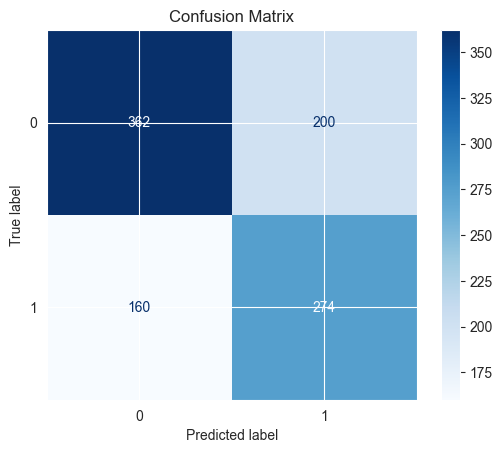

In [161]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

#### Feature importance

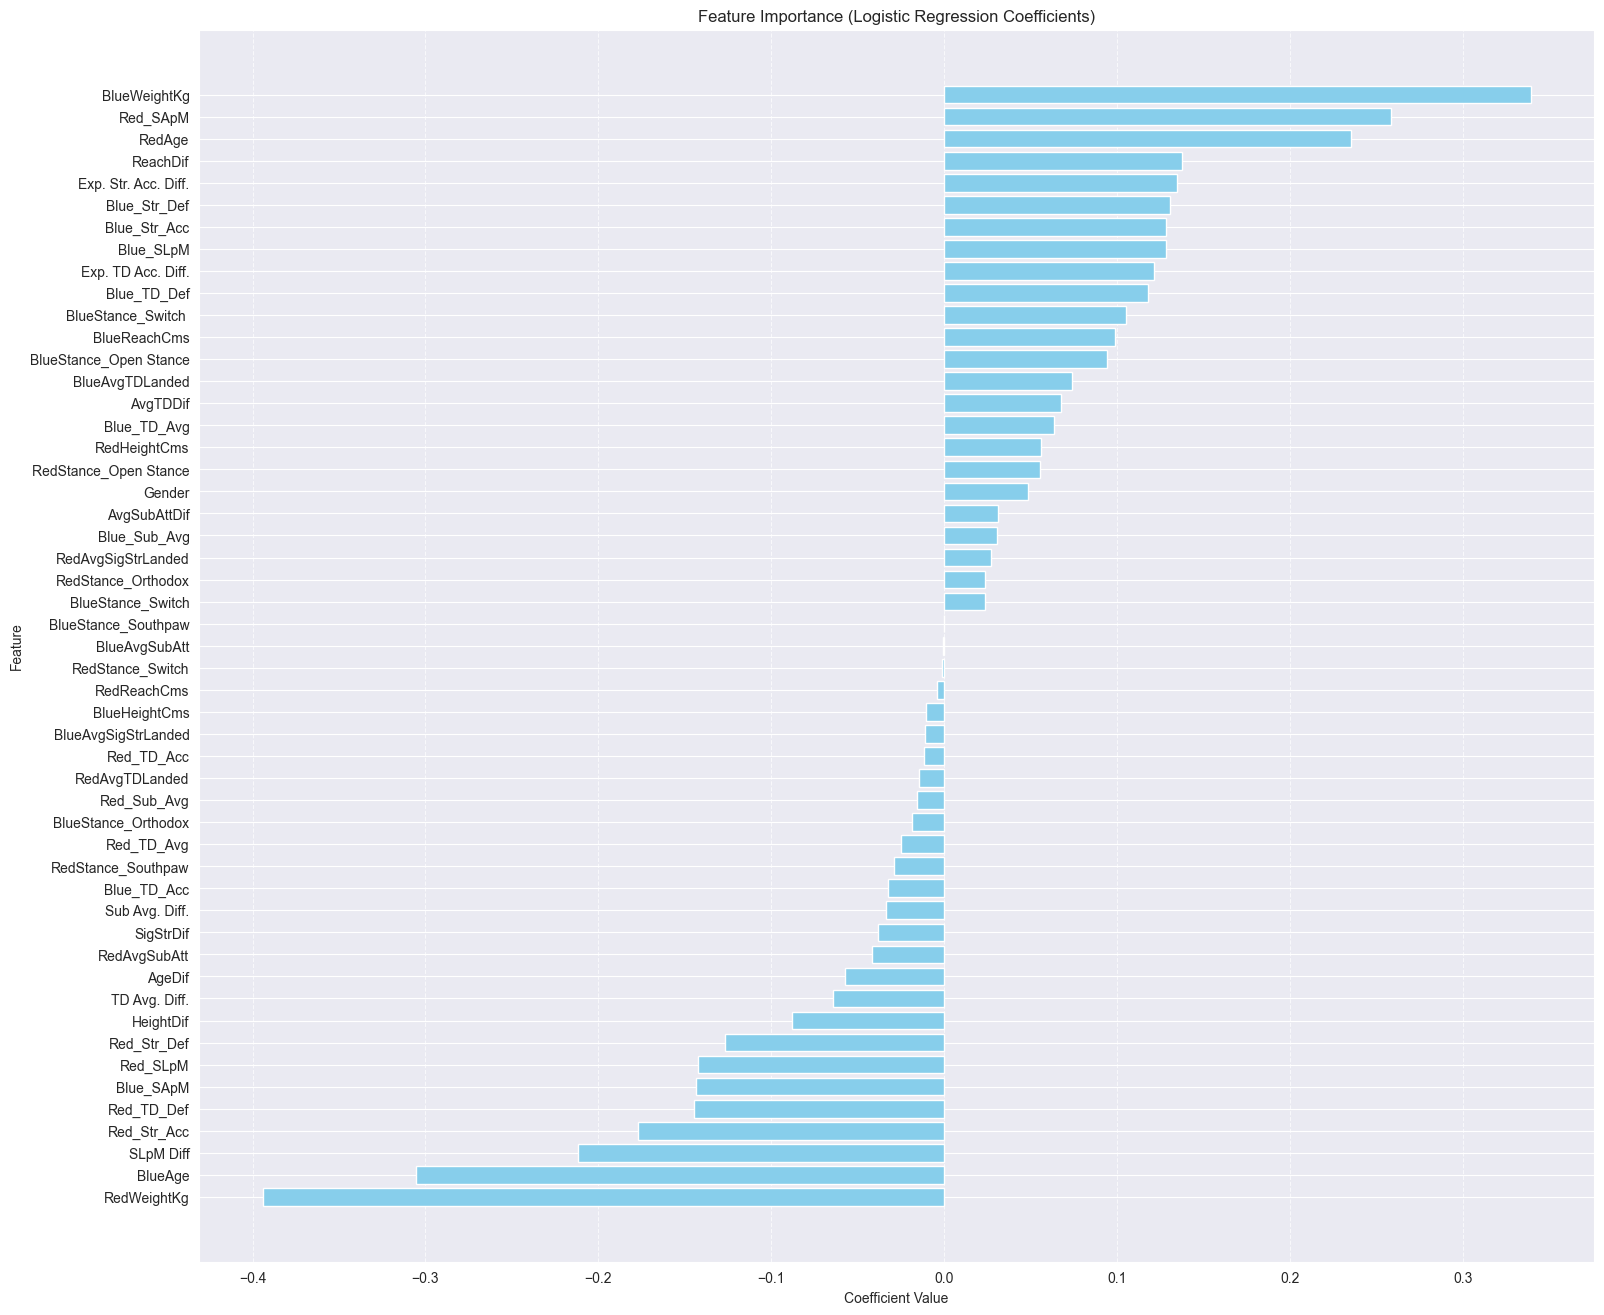

In [163]:
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_[0] 
}).sort_values(by='Coefficient', ascending=True)

plt.figure(figsize=(18, 16))
plt.barh(feature_importance['Feature'], feature_importance['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importance (Logistic Regression Coefficients)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

#### Balancing the set

##### Hyperparameter tuning

Best Parameters: {'C': 0.01, 'solver': 'liblinear'}
R-squared (R²): 0.06
Logistic Regression model accuracy (in %): 62.44979919678715
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.83      0.71       562
           1       0.62      0.36      0.45       434

    accuracy                           0.62       996
   macro avg       0.62      0.59      0.58       996
weighted avg       0.62      0.62      0.60       996



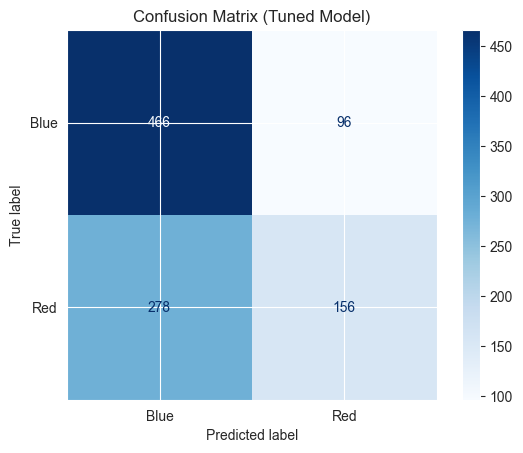

In [144]:
# Define the parameter grid for tuning
param_grid = {'C': [0.01, 0.1, 1, 10], 'solver': ['liblinear', 'lbfgs']}

grid_search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring='r2')
grid_search.fit(x_train, y_train)

print("Best Parameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)
y_pred_proba = best_model.predict_proba(x_test)

r2 = r2_score(pd.get_dummies(y_test), y_pred_proba)
print(f"R-squared (R²): {r2:.2f}")

acc = accuracy_score(y_test, y_pred)
print("Logistic Regression model accuracy (in %):", acc * 100)

print("Classification Report:")
print(classification_report(y_test, y_pred))

disp = ConfusionMatrixDisplay.from_estimator(best_model, x_test, y_test, display_labels=['Blue', 'Red'], cmap='Blues')
disp.ax_.set_title("Confusion Matrix (Tuned Model)")
plt.show()


##### Undersampling

In [ ]:
# Combine features and target into a single DataFrame
data_combined = pd.concat([pd.DataFrame(X), y.reset_index(drop=True)], axis=1)
data_combined.columns = list(X.columns) + ['Winner']

# Separate the minority and majority classes
majority_class = data_combined[data_combined['Winner'] == 0]  # Blue
minority_class = data_combined[data_combined['Winner'] == 1]  # Red

# Undersample the majority class
majority_undersampled = resample(majority_class,
                                  replace=False,  # Sample without replacement
                                  n_samples=len(minority_class),  # Match minority class size
                                  random_state=42)

# Combine the undersampled majority class with the minority class
undersampled_data = pd.concat([majority_undersampled, minority_class])

X_undersampled = undersampled_data.drop(columns=['Winner'])
y_undersampled = undersampled_data['Winner']

X_train, X_test, y_train, y_test = train_test_split(X_undersampled, y_undersampled, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

# If they do not match, slice y_pred_proba to match y_test
if len(y_test) != len(y_pred_proba):
    y_pred_proba = y_pred_proba[:len(y_test)]  # Ensure lengths match

y_test_encoded = pd.get_dummies(y_test)

r2 = r2_score(y_test_encoded, y_pred_proba)
print(f"R-squared (R²): {r2:.2f}")

y_pred = model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

In [ ]:
# Confusion matrix for Undersampling
disp = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=['Blue', 'Red'], cmap='Blues')
disp.ax_.set_title("Confusion Matrix (Undersampled Data)")
plt.show()

##### Oversampling

In [164]:
X = pd.DataFrame(X_scaled, columns=X.columns) 
y = y 

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# print("Class distribution after SMOTE:")
# print(y_resampled.value_counts())

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

r2 = r2_score(y_test_encoded, y_pred_proba)
print(f"R-squared (R²): {r2:.2f}")

y_pred = model.predict(X_test)
print("Classification Report (Oversampled Data):")
print(classification_report(y_test, y_pred))


ValueError: Found input variables with inconsistent numbers of samples: [856, 996]

In [ ]:
# Confusion matrix for oversampling
disp = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=['Blue', 'Red'], cmap='Blues')
disp.ax_.set_title("Confusion Matrix (Oversampled Data)")
plt.show()

## Example fight prediction

In [ ]:
# Prepare data for the simulated match
# Mapping fighter stats into a similar structure as the master dataset
match_data = {
    "RedAvgSigStrLanded": [4.1],  # Khabib's SLpM
    "RedAvgSubAtt": [0.8],       # Khabib's Sub Avg
    "RedAvgTDLanded": [5.32],    # Khabib's TD Avg
    "BlueAvgSigStrLanded": [2.0],  # Islam's SLpM
    "BlueAvgSubAtt": [1.0],        # Islam's Sub Avg
    "BlueAvgTDLanded": [3.46],     # Islam's TD Avg
    # Additional features can be filled or averaged if required
}

# Convert match data to DataFrame and fill in missing columns with 0
match_df = pd.DataFrame(match_data)
for col in X.columns:
    if col not in match_df.columns:
        match_df[col] = 0

# Scale the match data
match_scaled = scaler.transform(match_df[X.columns])

# Predict probabilities for the match
match_probabilities = model.predict_proba(match_scaled)

# Map predictions to outcome labels
outcome_probabilities = dict(zip(model.classes_, match_probabilities[0]))

outcome_probabilities


# Data from Kaggle (Data)

In [ ]:
ufc_data = pd.read_excel('UFCData/data.xlsx')

ufc_data.column

## Creating a separate sheet with statistics from both fighters

In [ ]:
## Printing all column names for analysis

pd.options.display.max_columns = None

column_names_ufc_data = ufc_data.columns

print(list(ufc_data.columns))

In [ ]:
data = pd.ExcelFile('data.xlsx')

sheet_data = data.parse(data.sheet_names[0])

horizontal_list = [f"{col} ({dtype})" for col, dtype in zip(sheet_data.columns, sheet_data.dtypes)]

horizontal_list

In [ ]:
stance_mapping = {'Switch' : 0, 'Orthodox': 1, 'Southpaw': 2}

ufc_data['R_Stance'] = ufc_data['R_Stance'].map(stance_mapping)

# ufc_data.to_excel('Updated_UFC_File.xlsx', index=False)

ufc_data.head()

In [ ]:
stance_mapping = {'Switch' : 0, 'Orthodox': 1, 'Southpaw': 2}

ufc_data['B_Stance'] = ufc_data['B_Stance'].map(stance_mapping)
ufc_data['R_Stance'] = ufc_data['R_Stance'].map(stance_mapping)

ufc_data.to_excel('Updated_UFC_File.xlsx', index=False)

ufc_data.head()

## Mapping 'Winner' to -1, 0, 1

In [ ]:
print(ufc_data['Winner'].unique())
ufc_data['Winner'] = ufc_data['Winner'].map({'Red': 1, 'Blue': -1, 'Draw': 0})

ufc_data.head()


# ufc_data['Winner'] = ufc_data['Winner'].map({'Red': 1, 'Blue': -1, 'Draw': 0})
# 
# ufc_data.head(20)

In [ ]:
Combined_stats = [
    # Blue Corner Stats
    'B_avg_KD', 'B_avg_opp_KD', 'B_avg_SIG_STR_pct', 'B_avg_opp_SIG_STR_pct',
    'B_avg_TD_pct', 'B_avg_opp_TD_pct', 'B_avg_SUB_ATT', 'B_avg_opp_SUB_ATT',
    'B_avg_REV', 'B_avg_opp_REV', 'B_avg_SIG_STR_att', 'B_avg_SIG_STR_landed',
    'B_avg_opp_SIG_STR_att', 'B_avg_opp_SIG_STR_landed', 'B_avg_TOTAL_STR_att',
    'B_avg_TOTAL_STR_landed', 'B_avg_opp_TOTAL_STR_att', 'B_avg_opp_TOTAL_STR_landed',
    'B_avg_TD_att', 'B_avg_TD_landed', 'B_avg_opp_TD_att', 'B_avg_opp_TD_landed',
    'B_avg_HEAD_att', 'B_avg_HEAD_landed', 'B_avg_opp_HEAD_att', 'B_avg_opp_HEAD_landed',
    'B_avg_BODY_att', 'B_avg_BODY_landed', 'B_avg_opp_BODY_att', 'B_avg_opp_BODY_landed',
    'B_avg_LEG_att', 'B_avg_LEG_landed', 'B_avg_opp_LEG_att', 'B_avg_opp_LEG_landed',
    'B_avg_DISTANCE_att', 'B_avg_DISTANCE_landed', 'B_avg_opp_DISTANCE_att',
    'B_avg_opp_DISTANCE_landed', 'B_avg_CLINCH_att', 'B_avg_CLINCH_landed',
    'B_avg_opp_CLINCH_att', 'B_avg_opp_CLINCH_landed', 'B_avg_GROUND_att',
    'B_avg_GROUND_landed', 'B_avg_opp_GROUND_att', 'B_avg_opp_GROUND_landed',
    'B_avg_CTRL_time(seconds)', 'B_avg_opp_CTRL_time(seconds)', 'B_total_time_fought(seconds)',
    'B_Height_cms', 'B_Reach_cms',
    
# ]
# 
# R_stats = [
    # Red Corner Stats
    'R_avg_KD', 'R_avg_SIG_STR_pct', 'R_avg_TD_pct', 'R_avg_SUB_ATT', 'R_avg_REV',
    'R_avg_SIG_STR_landed', 'R_avg_DISTANCE_landed', 'R_avg_CLINCH_landed',
    'R_avg_opp_KD', 'R_avg_opp_SIG_STR_pct', 'R_avg_opp_TD_pct', 'R_avg_opp_SUB_ATT',
    'R_avg_opp_REV', 'R_avg_SIG_STR_att', 'R_avg_opp_SIG_STR_att', 'R_avg_opp_SIG_STR_landed',
    'R_avg_TOTAL_STR_att', 'R_avg_TOTAL_STR_landed', 'R_avg_opp_TOTAL_STR_att',
    'R_avg_opp_TOTAL_STR_landed', 'R_avg_TD_att', 'R_avg_TD_landed', 'R_avg_opp_TD_att',
    'R_avg_opp_TD_landed', 'R_avg_HEAD_att', 'R_avg_HEAD_landed', 'R_avg_opp_HEAD_att',
    'R_avg_opp_HEAD_landed', 'R_avg_BODY_att', 'R_avg_BODY_landed', 'R_avg_opp_BODY_att',
    'R_avg_opp_BODY_landed', 'R_avg_LEG_att', 'R_avg_LEG_landed', 'R_avg_opp_LEG_att',
    'R_avg_opp_LEG_landed', 'R_avg_DISTANCE_att', 'R_avg_opp_DISTANCE_att',
    'R_avg_CLINCH_att', 'R_avg_opp_CLINCH_att', 'R_avg_GROUND_att', 'R_avg_GROUND_landed',
    'R_avg_opp_GROUND_att', 'R_avg_opp_GROUND_landed', 'R_avg_CTRL_time(seconds)',
    'R_avg_opp_CTRL_time(seconds)', 'R_total_time_fought(seconds)',
    'R_Height_cms', 'R_Reach_cms',
]

sheet_data['R_win_by_KO/TKO'] = sheet_data.apply(
    lambda row: 1 if row['Winner'] == 'Decision - Majority' else 0, axis=1
)

analysis_data = sheet_data[Combined_stats + ['R_win_by_KO/TKO']]

analysis_data = analysis_data.dropna()

correlation_matrix = analysis_data.corr()

plt.figure(figsize=(40, 30))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap with Fight_Win_by_Decision_Majority')
# plt.show()


## Modelling
The F1 Score is a metric used to evaluate a classification model. It combines precision and recall into a single metric.

In [ ]:
from sklearn.metrics import f1_score
from sklearn.multioutput import MultiOutputClassifier

X = ufc_data[Combined_stats]
y = ufc_data[['Winner']]

X = X.fillna(0)
y = y.fillna(0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Multilabel Classification Model
rf_model = RandomForestClassifier(random_state=42)
multi_output_model = MultiOutputClassifier(rf_model)

multi_output_model.fit(X_train, y_train)

y_pred = multi_output_model.predict(X_test)

for i, target in enumerate(y.columns):
    print(f"Evaluating {target}:")
    print("Accuracy:", accuracy_score(y_test[target], y_pred[:, i]))
    print("F1 Score:", f1_score(y_test[target], y_pred[:, i], average='weighted'))

# for i, target in enumerate(y.columns):
#     print(f"Feature Importance for {target}:")
#     feature_importances = pd.DataFrame({
#         'Feature': X_train.columns,
#         'Importance': multi_output_model.estimators_[i].feature_importances_
#     }).sort_values(by='Importance', ascending=False)
#     print(feature_importances)

## Random Forest Regressor
MSE needs to be a low number, this indicates that the model is performing well

R^2 needs to be close to one indicating better fit

If any R2R2 values are negative, it means the model performs worse than predicting the mean of the target variable

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

rf_regressor = RandomForestRegressor(random_state=42)

rf_regressor.fit(X_train, y_train)

y_pred = rf_regressor.predict(X_test)

threshold = 0.1

scores = []
for i, col in enumerate(y.columns):

    r2 = r2_score(y_test[col], y_pred[:, i])
    
    mse = mean_squared_error(y_test[col], y_pred[:, i])
    
    correct_predictions = abs(y_pred[:, i] - y_test[col]) <= threshold
    accuracy = correct_predictions.sum() / len(y_test[col])
    
    scores.append({'Target': col, 'R2 Score': r2, 'MSE': mse, 'Accuracy': accuracy})
    print(f"Scores for {col}:")
    print(f"  R² Score: {r2:.4f}")
    print(f"  MSE: {mse:.4f}")
    print(f"  Accuracy: {accuracy:.4f}")

scores_df = pd.DataFrame(scores)

print(scores_df)


## Gradient Boosting (XGBoost)

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error

# Initialize placeholders for R² and MSE scores
r2_scores = []
mse_scores = []

# Train and evaluate a separate XGBRegressor for each target column
for col in y.columns:
    # Train a model for the current target
    xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
    xgb_model.fit(X_train, y_train[col])  # Train on the current target
    
    # Predict for the current target
    y_pred_xgb = xgb_model.predict(X_test)
    
    # Evaluate R² and MSE
    r2 = r2_score(y_test[col], y_pred_xgb)
    mse = mean_squared_error(y_test[col], y_pred_xgb)
    
    # Store scores
    r2_scores.append(r2)
    mse_scores.append(mse)
    
    # Print scores for the current target
    print(f"R² Score for {col} (XGBoost): {r2}")
    print(f"MSE for {col} (XGBoost): {mse}")


## Support Vector Regressor

## Data visualization

In [ ]:
accuracy_scores = [accuracy_score(y_test[col], y_pred[:, i]) for i, col in enumerate(y.columns)]

plt.bar(y.columns, accuracy_scores)
plt.title("Accuracy Scores for Each Target")
plt.ylabel("Accuracy Score")
plt.xlabel("Target")
plt.show()


## Probability prediction visualization

In [ ]:
prob_df.plot(kind='bar', figsize=(10, 6))
plt.title("Predicted Probabilities for KO/TKO, Submission, and Decision")
plt.ylabel("Probability")
plt.xlabel("Data Points")
plt.legend(loc='upper right')
plt.show()


## Visualizing Feature Importances

In [ ]:
for i, target in enumerate(y.columns):
    feature_importances = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': multi_output_model.estimators_[i].feature_importances_
    }).sort_values(by='Importance', ascending=False)

    # Plot the top 10 important features
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importances['Feature'][:10], feature_importances['Importance'][:10])
    plt.title(f"Feature Importance for {target}")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.gca().invert_yaxis()  # Invert y-axis for descending order
    plt.show()


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

missing_features = [col for col in R_stats if col not in ufc_data.columns]
if missing_features:
    print(f"Missing features: {missing_features}")
else:
    print("All features are present.")

X = ufc_data[R_stats]
y = ufc_data['R_win_by_KO/TKO']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importances)
